In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")


# Load data

In [25]:


fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_country = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


# Basic inspection

In [3]:
fraud.head()
fraud.info()
fraud.describe()
fraud.isnull().sum()
fraud.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


np.int64(0)

# Data cleaning & preprocessing

In [5]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])


# Class imbalance analysis

In [6]:
fraud['class'].value_counts()


class
0    136961
1     14151
Name: count, dtype: int64

In [7]:
fraud['class'].value_counts(normalize=True) * 100


class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

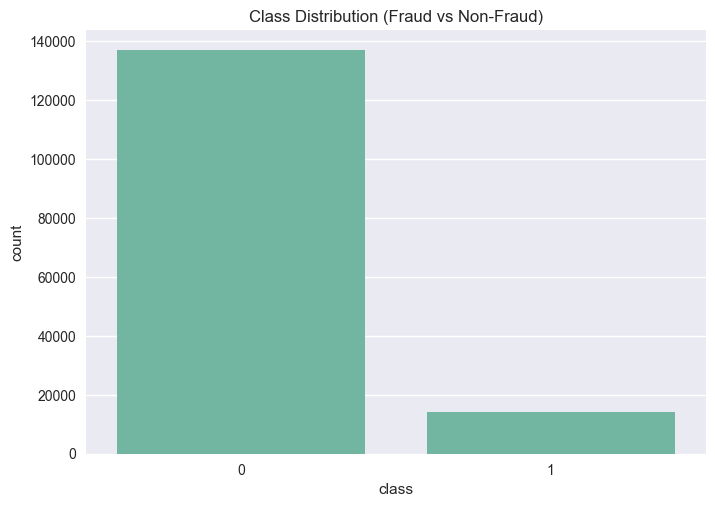

In [8]:
sns.countplot(x='class', data=fraud)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()


# Univariate analysis

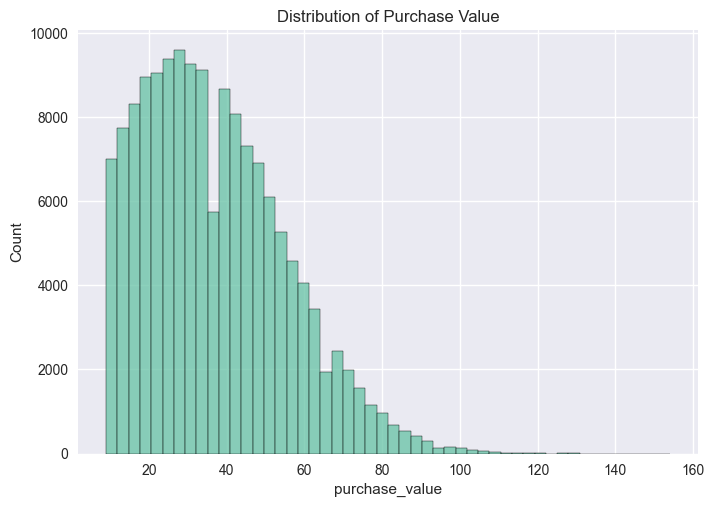

In [9]:
sns.histplot(fraud['purchase_value'], bins=50)
plt.title("Distribution of Purchase Value")
plt.show()


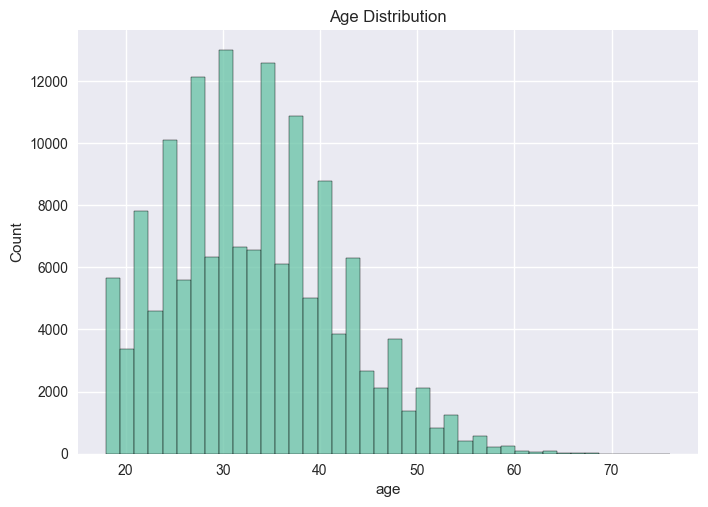

In [10]:
sns.histplot(fraud['age'], bins=40)
plt.title("Age Distribution")
plt.show()


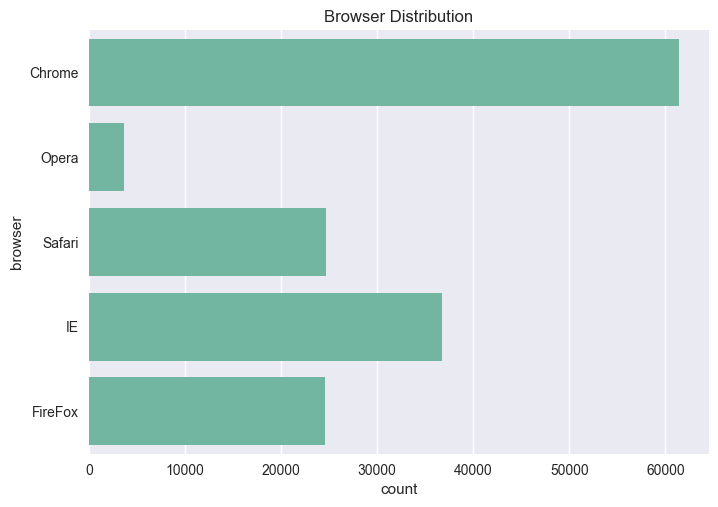

In [11]:
sns.countplot(y='browser', data=fraud)
plt.title("Browser Distribution")
plt.show()


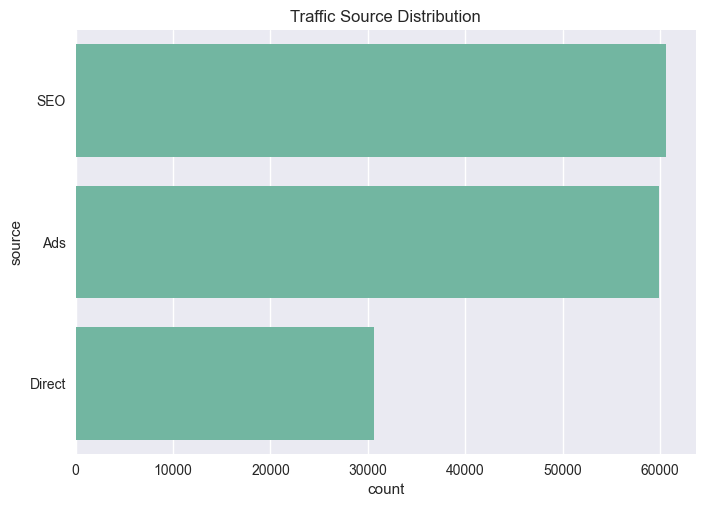

In [12]:
sns.countplot(y='source', data=fraud)
plt.title("Traffic Source Distribution")
plt.show()


# Bivariate analysis (feature vs fraud)

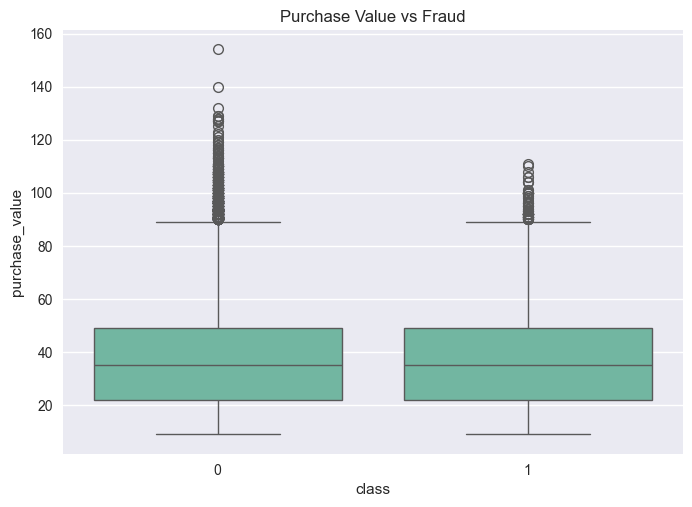

In [13]:
sns.boxplot(x='class', y='purchase_value', data=fraud)
plt.title("Purchase Value vs Fraud")
plt.show()


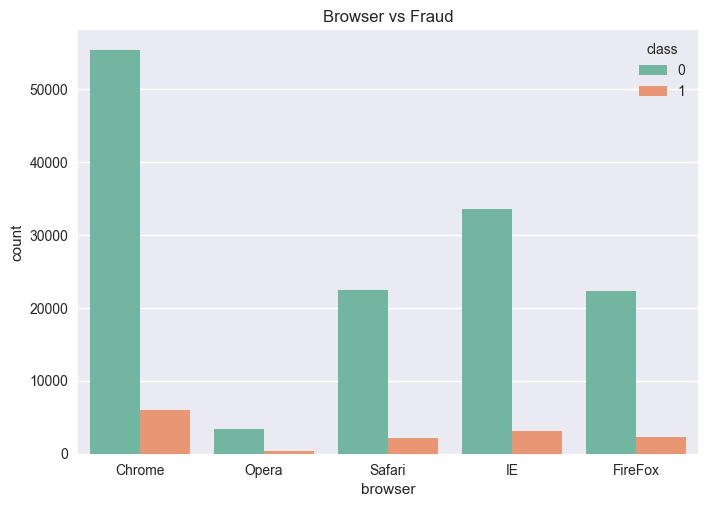

In [14]:
sns.countplot(x='browser', hue='class', data=fraud)
plt.title("Browser vs Fraud")
plt.show()


# IP address → integer conversion

In [19]:
fraud['ip_address'].head()
fraud['ip_address'].dtype


dtype('float64')

In [26]:
fraud['ip_int'] = fraud['ip_address'].astype('int64')



In [27]:
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype('int64')
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype('int64')




# Merge fraud data with country data

In [28]:
fraud = fraud.sort_values('ip_int')
ip_country = ip_country.sort_values('lower_bound_ip_address')

fraud = pd.merge_asof(
    fraud,
    ip_country,
    left_on='ip_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)


# Fraud analysis by country

In [29]:
country_fraud_rate = (
    fraud.groupby('country')['class']
    .mean()
    .sort_values(ascending=False)
)

country_fraud_rate.head(10)


country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

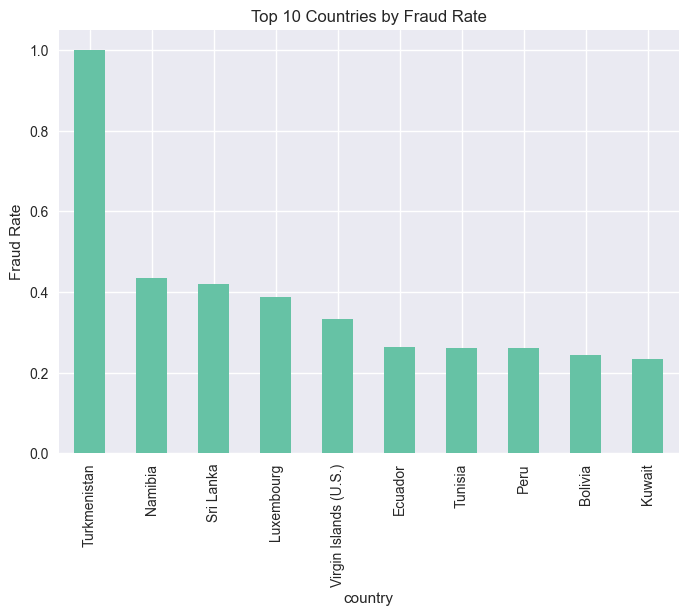

In [30]:
country_fraud_rate.head(10).plot(kind='bar')
plt.title("Top 10 Countries by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()


# Time since signup

In [33]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'], errors='coerce')
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'], errors='coerce')


In [34]:
fraud['time_since_signup'] = (
    fraud['purchase_time'] - fraud['signup_time']
).dt.total_seconds()


# Time-based features

In [35]:
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek


# Transaction frequency

In [36]:
fraud['user_transaction_count'] = (
    fraud.groupby('user_id')['user_id'].transform('count')
)


# Save processed dataset

In [39]:
fraud.to_csv("../data/processed/fraud_processed.csv", index=False)
